In [1]:
# Copyright (c) 2021, InterDigital R&D France. All rights reserved.
#
# This source code is made available under the license found in the
# LICENSE.txt in the root directory of this source tree.
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import glob
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import yaml

from PIL import Image
from torchvision import transforms, utils, models

import sys

if os.getcwd().split('/')[-1] == 'notebooks':
    sys.path.append('..')
    os.chdir('..')

from datasets import *
from original_trainer import *
from utils.functions import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(True)
Image.MAX_IMAGE_PIXELS = None
device = torch.device('cuda')

parser = argparse.ArgumentParser()
parser.add_argument('--config', type=str, default='001', help='Path to the config file.')
parser.add_argument('--attr', type=str, default='Eyeglasses', help='attribute for manipulation.')
parser.add_argument('--latent_path', type=str, default='./data/celebahq_dlatents_psp.npy', help='dataset path')
parser.add_argument('--label_file', type=str, default='./data/celebahq_anno.npy', help='label file path')
parser.add_argument('--stylegan_model_path', type=str, default='./pixel2style2pixel/pretrained_models/psp_ffhq_encode.pt', help='stylegan model path')
parser.add_argument('--classifier_model_path', type=str, default='./models/latent_classifier_epoch_20.pth', help='pretrained attribute classifier')
parser.add_argument('--log_path', type=str, default='./logs/', help='log file path')
opts = parser.parse_args([])

# Celeba attribute list
attr_dict = {'5_o_Clock_Shadow': 0, 'Arched_Eyebrows': 1, 'Attractive': 2, 'Bags_Under_Eyes': 3, \
            'Bald': 4, 'Bangs': 5, 'Big_Lips': 6, 'Big_Nose': 7, 'Black_Hair': 8, 'Blond_Hair': 9, \
            'Blurry': 10, 'Brown_Hair': 11, 'Bushy_Eyebrows': 12, 'Chubby': 13, 'Double_Chin': 14, \
            'Eyeglasses': 15, 'Goatee': 16, 'Gray_Hair': 17, 'Heavy_Makeup': 18, 'High_Cheekbones': 19, \
            'Male': 20, 'Mouth_Slightly_Open': 21, 'Mustache': 22, 'Narrow_Eyes': 23, 'No_Beard': 24, \
            'Oval_Face': 25, 'Pale_Skin': 26, 'Pointy_Nose': 27, 'Receding_Hairline': 28, 'Rosy_Cheeks': 29, \
            'Sideburns': 30, 'Smiling': 31, 'Straight_Hair': 32, 'Wavy_Hair': 33, 'Wearing_Earrings': 34, \
            'Wearing_Hat': 35, 'Wearing_Lipstick': 36, 'Wearing_Necklace': 37, 'Wearing_Necktie': 38, 'Young': 39}

In [2]:
# Initialize trainer model.
log_dir = os.path.join(opts.log_path, opts.config) + '/'
config = yaml.safe_load(open('./configs/' + opts.config + '.yaml', 'r'))

trainer = Trainer(config, None, None, opts.label_file)
trainer.initialize(opts.stylegan_model_path, opts.classifier_model_path)   
trainer.to(device)
print('Load model.')

Load model.


### Figure 1. Teaser

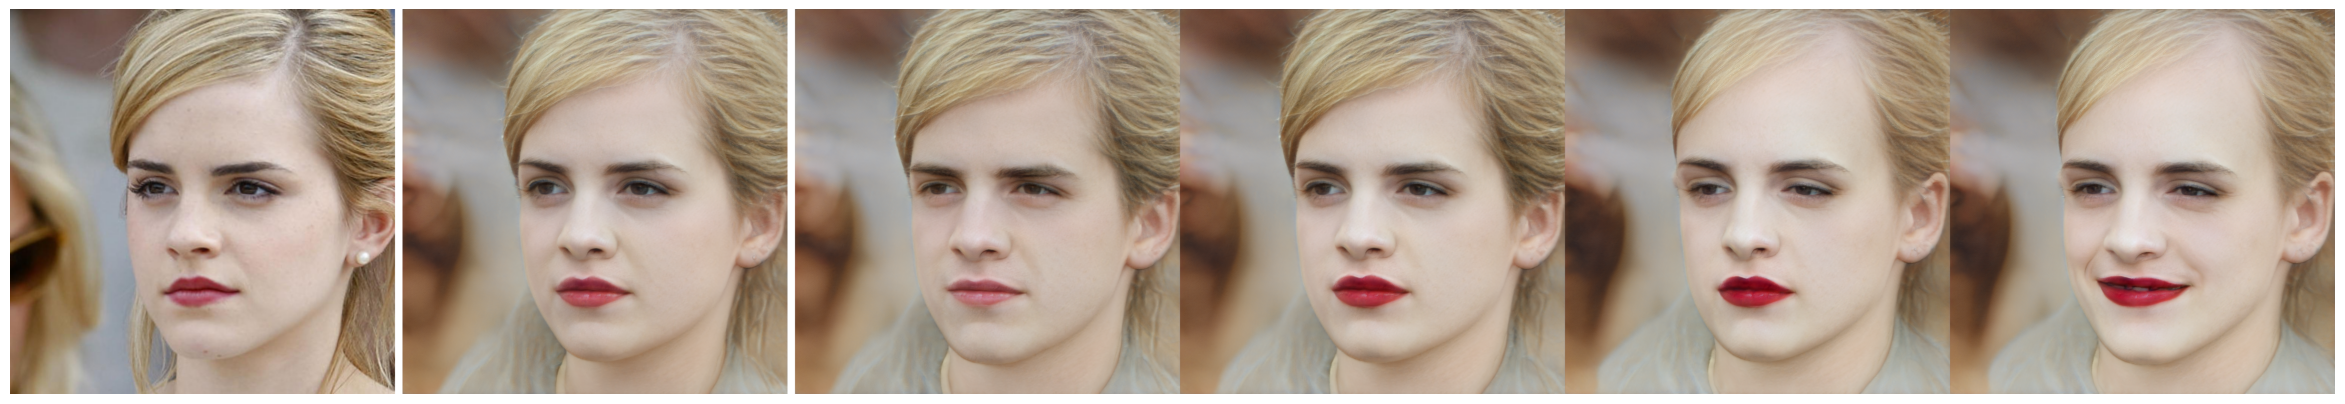

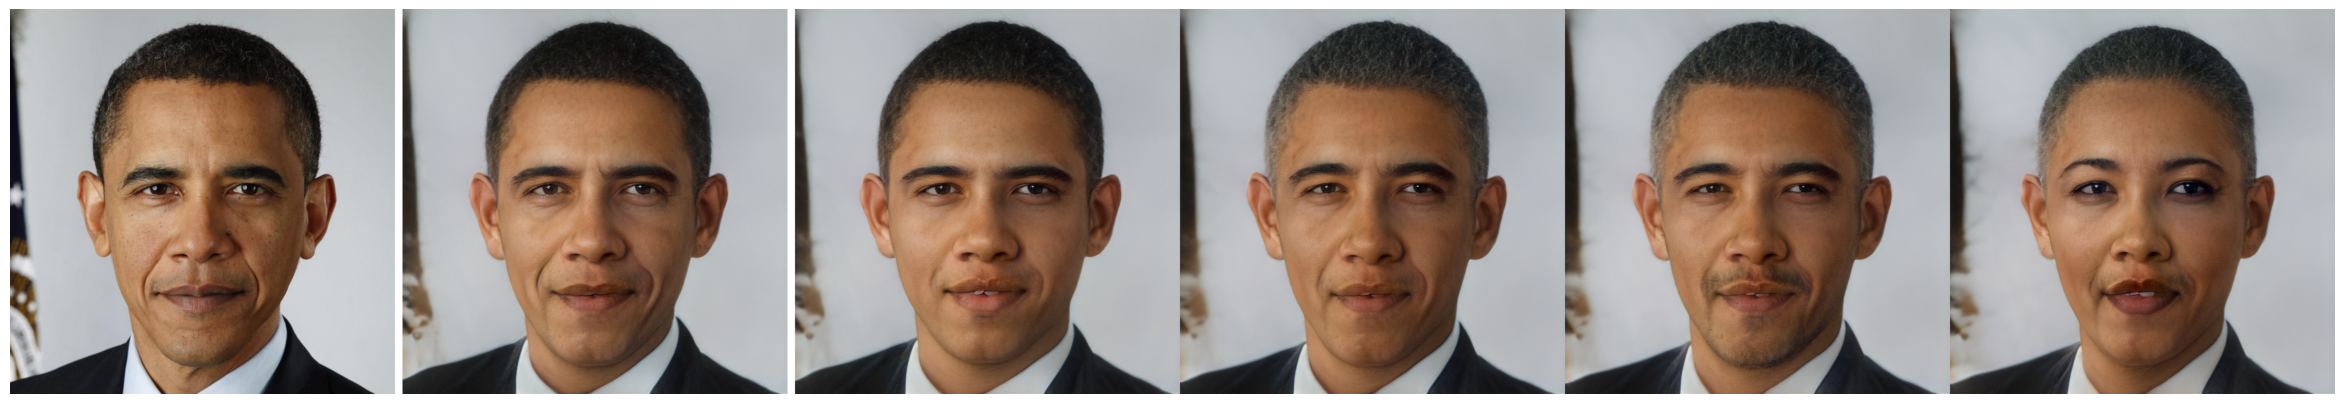

In [19]:
%matplotlib inline
testdata_dir = './data/teaser/'

teaser_attrs = [{'Male':1, 'Wearing_Lipstick':1, 'Bald':1, 'Smiling':1}, \
                {'Young':1, 'Gray_Hair':1, 'No_Beard':-1, 'Male':-1}  ]

with torch.no_grad():
    
    for k, idx in enumerate([1,2]):

        w_0 = np.load(testdata_dir + 'latent_code_%05d.npy'%idx)
        w_0 = torch.tensor(w_0).to(device)
        
        x_0 = img_to_tensor(Image.open(testdata_dir + '%05d.jpg'%idx))
        x_0 = x_0.unsqueeze(0).to(device)
        img_l = [x_0] # original image
        
        x_1, _ = trainer.StyleGAN([w_0], input_is_latent=True, randomize_noise=False)
        x_0 = torch.ones((x_1.size(0), x_1.size(1), x_1.size(2),x_1.size(3)+40)).type_as(x_1)
        x_0[:,:,:,20:1044] = x_1[:,:,:,:]
        img_l.append(x_0) # projected image
        
        w_1 = w_0
        attrs = teaser_attrs[k]
        for attr in list(attrs.keys()):
            
            trainer.attr_num = attr_dict[attr]
            trainer.load_model(log_dir)
            
            alpha = torch.tensor(1.0) * attrs[attr]
            w_1 = trainer.T_net(w_1.view(w_0.size(0), -1), alpha.unsqueeze(0).to(device))
            w_1 = w_1.view(w_0.size())
            w_1 = torch.cat((w_1[:,:11,:], w_0[:,11:,:]), 1)
            x_1, _ = trainer.StyleGAN([w_1], input_is_latent=True, randomize_noise=False)
            img_l.append(x_1.data)

        img = img_l[0] if len(img_l)==1 else torch.cat(img_l, 3)
        img = np.clip(clip_img(img)[0].cpu().numpy()*255.,0,255).astype(np.uint8)
        img = Image.fromarray(img.transpose(1,2,0))
        plt.figure(figsize=(30,5))
        plt.imshow(img)
        plt.axis('off')
plt.show()

### Figure 4. Sequential facial attribute editing

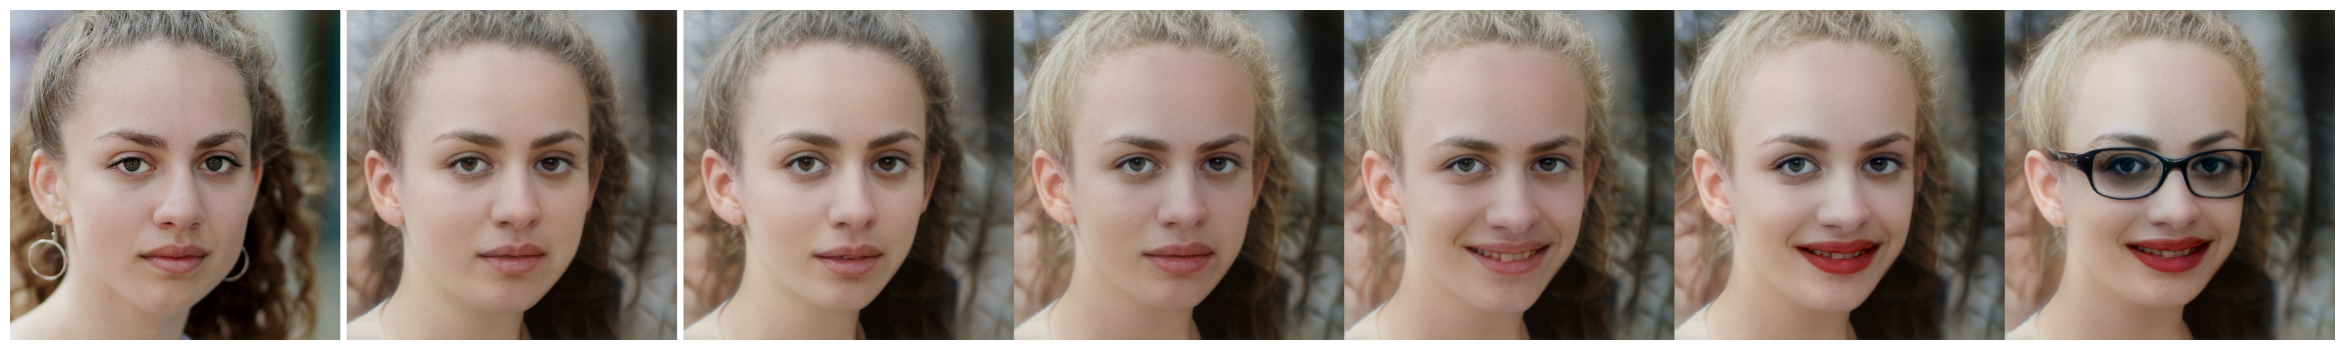

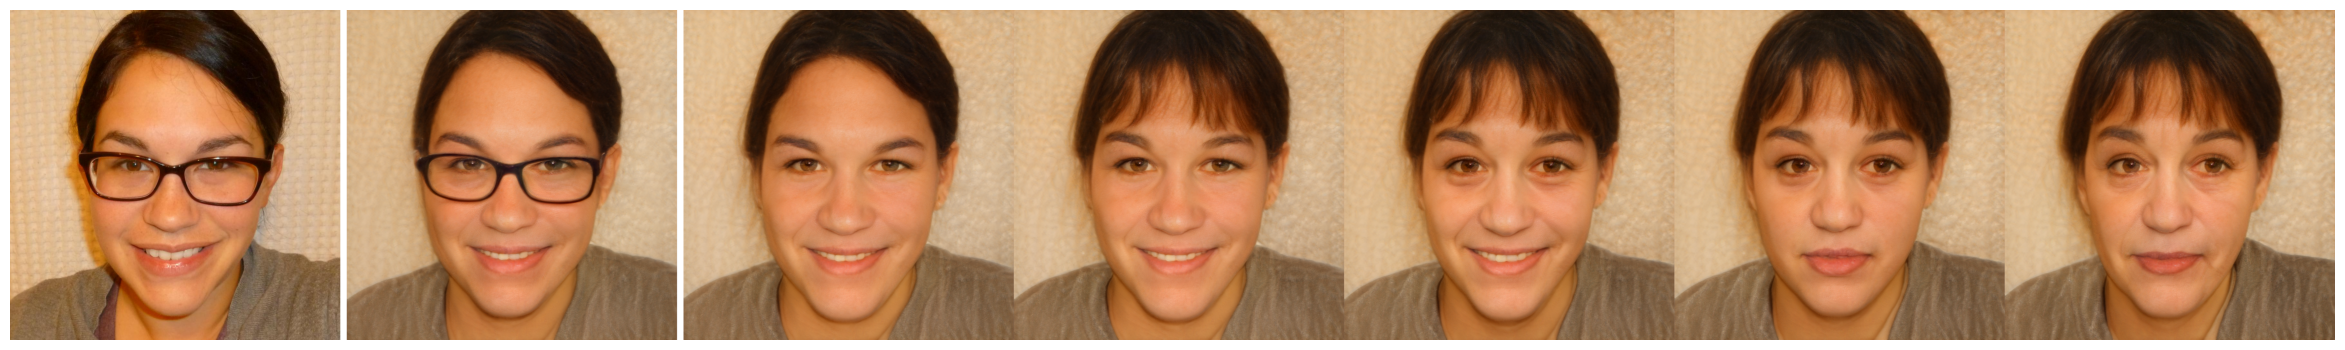

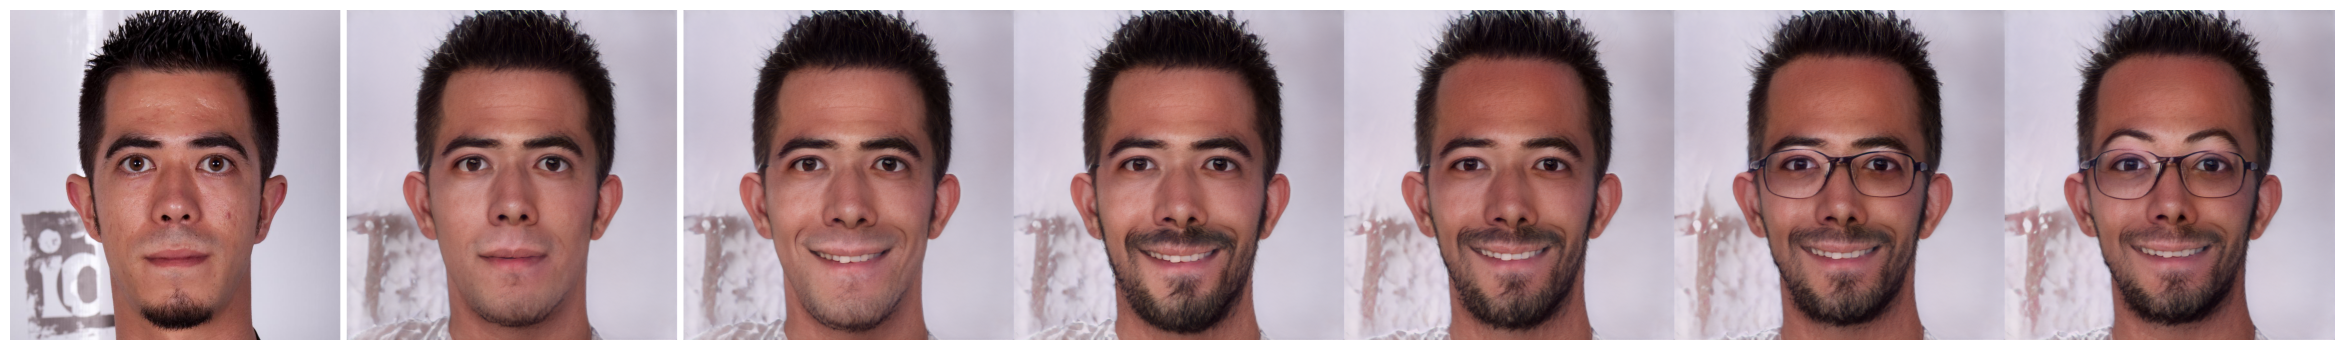

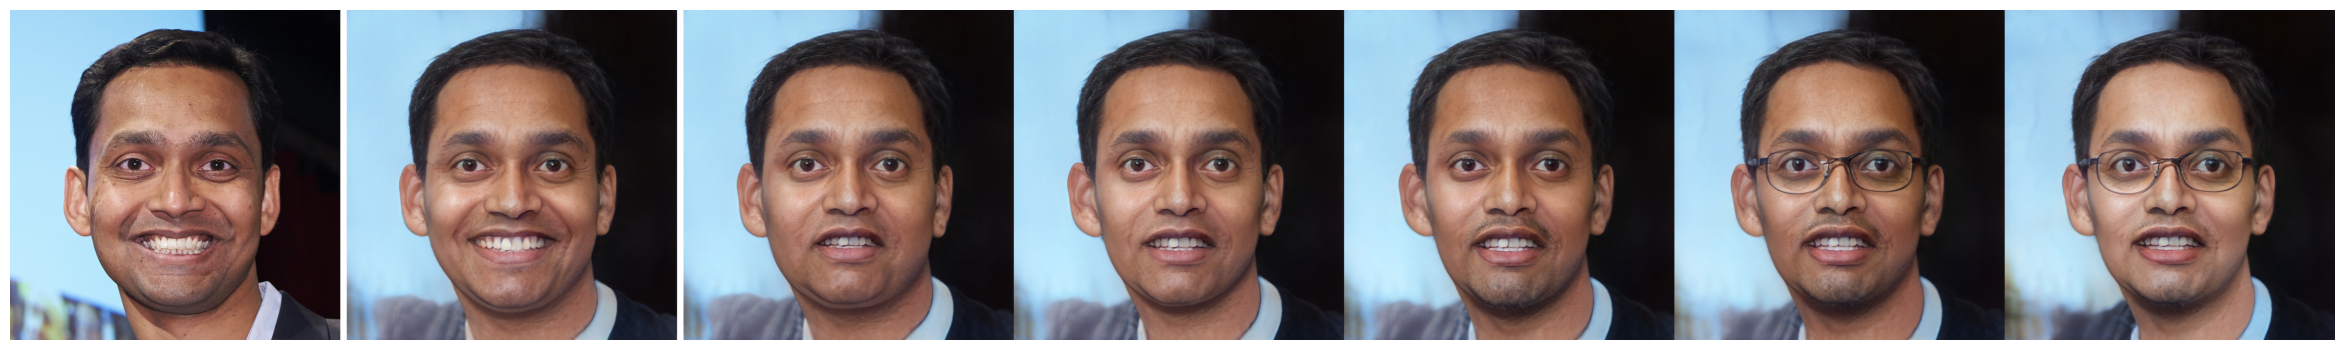

In [4]:
testdata_dir = './data/test/'

attrs_list = [{'Chubby':-0.5, 'Blond_Hair':1.5, 'Smiling':1, 'Wearing_Lipstick':1, 'Eyeglasses':1.5}, \
                {'Eyeglasses':-1.5, 'Bangs':1, 'Bags_Under_Eyes':1, 'Smiling':-1, 'Young':-1}, \
                {'Smiling':1, 'No_Beard':-1, 'Receding_Hairline':1, 'Eyeglasses':1, 'Arched_Eyebrows':1}, \
                {'Smiling':-1, 'Chubby':-0.5, 'Goatee':1, 'Eyeglasses':1, 'Pale_Skin':1}  ]

with torch.no_grad():
    
    for k, idx in enumerate([4,5,6,7]):

        w_0 = np.load(testdata_dir + 'latent_code_%05d.npy'%idx)
        w_0 = torch.tensor(w_0).to(device)
        
        x_0 = img_to_tensor(Image.open(testdata_dir + '%05d.jpg'%idx))
        x_0 = x_0.unsqueeze(0).to(device)
        img_l = [x_0] # original image
        
        x_1, _ = trainer.StyleGAN([w_0], input_is_latent=True, randomize_noise=False)
        x_0 = torch.ones((x_1.size(0), x_1.size(1), x_1.size(2),x_1.size(3)+40)).type_as(x_1)
        x_0[:,:,:,20:1044] = x_1[:,:,:,:]
        img_l.append(x_0) # projected image
        
        w_1 = w_0
        attrs = attrs_list[k]
        for attr in list(attrs.keys()):
            
            trainer.attr_num = attr_dict[attr]
            trainer.load_model(log_dir)
            
            alpha = torch.tensor(1.0) * attrs[attr]
            w_1 = trainer.T_net(w_1.view(w_0.size(0), -1), alpha.unsqueeze(0).to(device))
            w_1 = w_1.view(w_0.size())
            w_1 = torch.cat((w_1[:,:11,:], w_0[:,11:,:]), 1)
            x_1, _ = trainer.StyleGAN([w_1], input_is_latent=True, randomize_noise=False)
            img_l.append(x_1.data)

        img = img_l[0] if len(img_l)==1 else torch.cat(img_l, 3)
        img = np.clip(clip_img(img)[0].cpu().numpy()*255.,0,255).astype(np.uint8)
        img = Image.fromarray(img.transpose(1,2,0))
        plt.figure(figsize=(30,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()